In [43]:
try:
        
    import h5py
    
    from ipywidgets import widgets, Layout, interact, interactive, interactive_output, Dropdown
    from IPython.display import display

    import matplotlib.pyplot as mplt
    import numpy as np
    import random
    import seaborn as sns 
    import pandas as pd
    import graphing as gr
    #!pip install viola
    ########## Modules required for artist drawing on matplotlib
    import matplotlib.path as mpath
    import matplotlib.lines as mlines
    import matplotlib.patches as mpatches
    import matplotlib.ticker as ticker
    from matplotlib.collections import PatchCollection
    
      
except ModuleNotFoundError:
        print("A class you are trying to import is not present in the directory")
    
except Exception:
        print("Something went wrong - modules have not been imported")

else: 
    print("All relevant classes imported")

All relevant classes imported


In [53]:
#######################################################
#### GUI 

edt_filename = widgets.Text(description = 'File name', value='Experiment-F5')
btn_select = widgets.Button(description = 'Select file',button_style='success')
output_file = widgets.Output()

display(edt_filename, btn_select,output_file)



#######################################################
#### FUNCTIONS


#df_flux = pd.DataFrame({'Compartment':[],'Na_net':[], 'Na_leak':[],'Na_Atpase':[], 'K_net':[],'K_leak':[],'K_Atpase':[],'K_kcc2':[], 'Cl_net':[],'Cl_kcc2':[],'X':[],'z':[]  })
df_ed = pd.DataFrame({'Boundary':[],'Na':[],'K':[],'Cl':[]})



def btn_select_clicked(b):
    global file_name, df_end, df_start, df_end_flux, df_end_ed, df_end_net_flux
    file_name = "\\"
    file_name = file_name + edt_filename.value 
    
    try: 
        with h5py.File(file_name, mode='r') as hdf:
            
            print("File found and content loaded into memory")
            global C, comp_names_arr, intervals, interval_arr, master_arr, t_arr, ED_master_arr,E_group_arr
            C = hdf.get('COMPARTMENTS')
            C_group_arr =[]
            t_arr_bool = True
            comp_names_arr= list(C.keys())
                        
            C1 = C.get(comp_names_arr[0])
            
            T = hdf.get('TIMING')
            total_t = T.get('TOTAL_T')[()]
            intervals = T.get('INTERVALS')[()]
            dt = T.get("DT")[()]
            total_steps = total_t /dt          
            interval_step = total_steps / intervals
            interval_arr = [round(interval_step * i) for i in range(intervals)]
            
            master_arr = []
            t_arr =[]
            
            
            
            
            ##### LOADING COMPARTMENT DATA
            for e in range(len(comp_names_arr)):
                C_group = C.get(comp_names_arr[e])
                C_group_arr.append(C_group)
               
                data_arr_2 =[]
                for j in range(len(list(C_group.keys()))):
                    dataset = C_group.get(str(interval_arr[j]))
                    
                    data_arr = []
                    for d in range(len(list(dataset))):
                        data_arr.append(dataset[d])
                    
                    data_arr_2.append(data_arr)
            
                    if t_arr_bool == True:
                        t_arr.append(data_arr[0])         
                
                master_arr.append(data_arr_2)
                t_arr_bool = False
                
            
            #df_start['radius'] = 
            
            E = hdf.get('ELECTRODIFFUSION')
            E_group_arr = list(E.keys())
            ED_master_arr = []            
            
            ##### LOADING ELECTRODIFFUSION DATA
            for x in range(len(E_group_arr)): # Looping through the electrodiffusion groups on the file
                
                E_group = E.get(E_group_arr[x])
                
                ED_data_arr =[] #stores the electrodiffusion data for a group
                
                for y in range(len(list(E_group.keys()))-1): # Looping through all the datasets of the group
                    
                    dataset = E_group.get(str(interval_arr[y+1]))
                   
                    ED_data_arr_2 = [] #stores the dataset values for one dataset
                    for z in range(len(list(dataset))): # Looping through the individual datasets to extract data
                        ED_data_arr_2.append(dataset[z])
                    
                    
                    ED_data_arr.append(ED_data_arr_2) 
                    
            
                ED_master_arr.append(ED_data_arr) #contains all the electrodiffusion data for all the groups (1st index is the group, 2nd index is the interval)
            
            
        ################
        # DATAFRAMES
        ################
    
        # START VALUE DATAFRAME
        df_start_data = [master_arr[i][0][1:9] for i in range(len(comp_names_arr))]
        df_start=pd.DataFrame(data=df_start_data, index=comp_names_arr)
        df_start.columns = ['Radius', 'Length', 'Volume', 'Na_i', 'K_i', 'Cl_i','X_i','z_i']
        
        # END VALUE DATAFRAME
        df_end_data = [master_arr[i][-1][1:9] for i in range(len(comp_names_arr))]
        for i in range(len(comp_names_arr)):
            df_end_data[i].append(master_arr[i][-1][-3]*1e3) #vm
            df_end_data[i].append(master_arr[i][-1][-2]*1e3) #ek
            df_end_data[i].append(master_arr[i][-1][-1]*1e3) #ecl
            df_end_data[i].append((master_arr[i][-1][-3]-master_arr[i][-1][-1])*1e3) #driving force
            
        df_end=pd.DataFrame(data=df_end_data,index=comp_names_arr)
        df_end.columns = ['Radius', 'Length', 'Volume', 'Na_i', 'K_i', 'Cl_i','X_i','z_i','Vm (mV)','Ek (mV)','ECl (mV)','Cl-Driving force (mV)']
        
        
        # END TRANSMEMBRANE FLUX DATAFRAME
        
        final_mol_data =  [master_arr[i][-1][9:19]  for i in range(len(comp_names_arr))]
        #semifinal_mol_data =  [master_arr[i][-2][9:19]  for i in range(len(comp_names_arr))]
        
        df_end_flux_data = []
        
    
        for i in range(len(final_mol_data)):
            temp_arr =[]
            for j in range(len(final_mol_data[i])):
                final_mol_data[i][j] = final_mol_data[i][j] * master_arr[i][-1][3]
                #semifinal_mol_data[i][j] = semifinal_mol_data[i][j] * master_arr[i][-2][3]
                #temp_arr.append(final_mol_data[i][j]-semifinal_mol_data[i][j])
            #df_end_flux_data.append(temp_arr)
            
            
        df_end_flux_cols = ['Na_net', 'Na_leak','Na_Atpase', 'K_net','K_leak','K_Atpase','K_kcc2', 'Cl_net','Cl_leak','Cl_kcc2']
        df_end_flux = pd.DataFrame(data =final_mol_data, index = comp_names_arr, columns=df_end_flux_cols)
        
        # END ELECTRODIFFUSION DATAFRAME
        df_end_ed_data = [ED_master_arr[i][-1][0:3] for i in range(len(ED_master_arr))]
        for i in range(len(df_end_ed_data)):
            for j in range(3):
                df_end_ed_data[i][j] = df_end_ed_data[i][j] * master_arr[i][-1][3]
                    
        
        df_end_ed_cols = ['Na_ED_flux', 'K_ED_flux', 'Cl_ED_flux']
        df_end_ed = pd.DataFrame(data = df_end_ed_data, index = E_group_arr, columns=df_end_ed_cols)
        
        
        
        # NET FLUX DATAFRAME
        na_net_arr, k_net_arr,cl_net_arr,x_net_arr,total_net_arr = [],[],[],[],[]
       
        for i in range(len(comp_names_arr)):
            na_net_arr.append(df_end_flux.iloc[i][0])
            k_net_arr.append(df_end_flux.iloc[i][3])
            cl_net_arr.append(df_end_flux.iloc[i][7])

        x_net_arr = [((master_arr[i][-1][7] * master_arr[i][-1][3]) -(master_arr[i][-2][7] * master_arr[i][-2][3]))  for i in range(len(comp_names_arr))]
        #(master_arr[i][-2][7]- master_arr[i][-2][3]
        
        for j in range(len(E_group_arr)):
            na_net_arr[j] = na_net_arr[j] - df_end_ed.iloc[j][0]
            na_net_arr[j+1] = na_net_arr[j+1] + df_end_ed.iloc[j][0]
            k_net_arr[j] = k_net_arr[j] - df_end_ed.iloc[j][1]
            k_net_arr[j+1] = k_net_arr[j+1] + df_end_ed.iloc[j][1]
            cl_net_arr[j] = cl_net_arr[j] + df_end_ed.iloc[j][2]
            cl_net_arr[j+1] = cl_net_arr[j+1] - df_end_ed.iloc[j][2]

        total_net_arr = [na_net_arr[a]+k_net_arr[a]-cl_net_arr[a]-x_net_arr[a] for a in range(len(comp_names_arr))]


        df_end_net_flux = pd.DataFrame(data ={'Na-Net':na_net_arr, 'K-Net':k_net_arr,'Cl-Net':cl_net_arr,'X-Net':x_net_arr,'Total':total_net_arr }, index=comp_names_arr)     


            
    except: 
        raise("File not found")
        raise("File needs to be in base directory")


btn_select.on_click(btn_select_clicked)

Text(value='Experiment-F5', description='File name')

Button(button_style='success', description='Select file', style=ButtonStyle())

Output()

File found and content loaded into memory


# FIGURE 1A - elementary changes to conentration, charge and volume

['Comp9', 'Comp8', 'Comp7', 'Comp6', 'Comp5', 'Comp4', 'Comp3', 'Comp2', 'Comp1']


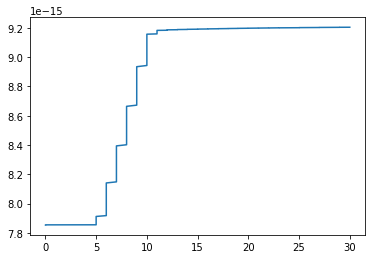

In [56]:
print(comp_names_arr[::-1])
vol_arr = [master_arr[-2][i][3] for i in range(len(t_arr))]
t2_arr = [round(t_arr[i]) for i in range(len(t_arr))]
mplt.plot(t2_arr,vol_arr)


Button(button_style='info', description='Plot 1A', style=ButtonStyle())

Output()

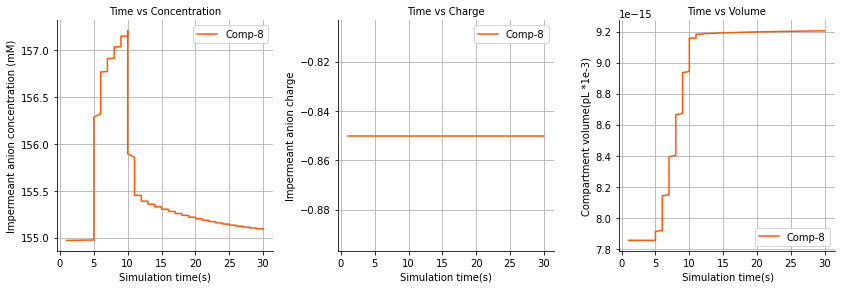

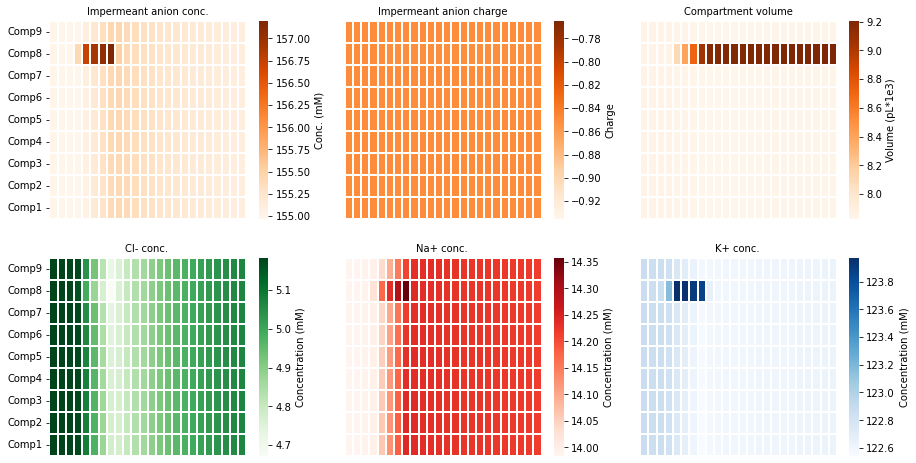

In [57]:
########################################
# GUI
########################################

btn_f1a = widgets.Button(description="Plot 1A", button_style='info')
output_f1a = widgets.Output()

display(btn_f1a, output_f1a)



########################################
# BACKEND
########################################
def btn_f1a_clicked(b):
    
    
    f1a, ((ax_x, ax_z, ax_vol)) = mplt.subplots(1,3, figsize=(12,4))
    f1a.tight_layout(pad=4.0)
    
    mplt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.1)

    t2_arr = [round(t_arr[i]) for i in range(len(t_arr))]
    
    z_arr = [master_arr[-2][i][8] for i in range(len(t2_arr))]
    vol_arr = [master_arr[-2][i][3] for i in range(len(t2_arr))]
    x_arr = [master_arr[-2][i][7]*1e3 for i in range(len(t2_arr))]
    
    ax_z.plot(t2_arr[50:], z_arr[50:], color = "#FF5800", label="Comp-8")
    ax_z.set_xlabel("Simulation time(s)")
    ax_z.set_ylabel("Impermeant anion charge")
    ax_z.set_title("Time vs Charge",fontsize=10)
    ax_z.grid()
    
    
    
    ax_vol.plot(t2_arr[50:], vol_arr[50:], color = "#FF5800", label="Comp-8")
    ax_vol.set_xlabel(" Simulation time(s)")
    ax_vol.set_ylabel("Compartment volume(pL *1e-3)")
    ax_vol.set_title("Time vs Volume",fontsize=10)
    ax_vol.grid()
    
    ax_x.plot(t2_arr[50:], x_arr[50:], color = "#FF5800", label="Comp-8")
    ax_x.set_xlabel("Simulation time(s)")
    ax_x.set_ylabel("Impermeant anion concentration (mM)")
    ax_x.set_title("Time vs Concentration",fontsize=10)
    ax_x.grid()
    ax_x.set_ylim(bottom=None, top=None, emit=True, auto=False)#, ymin=154.9, ymax=155.2)
   
  
    ax_z.legend()
    ax_vol.legend()
    ax_x.legend()
    sns.despine()
    
    
    f2a, ((ax_heatx, ax_heatz,ax_heatvol),(left_ax_lower, mid_ax_lower,right_ax_lower)) = mplt.subplots(2,3, figsize=(15,8))
    
    
    conc_arr, z_arr, vol_arr = [],[],[]
    bins = 25
    lower_right_arr, lower_mid_arr, lower_left_arr = [],[],[]
    
    for i in range(len(comp_names_arr)-1,-1,-1):

        temp_arr_conc = [master_arr[i][j][7] *1e3 for j in range(len(master_arr[0]))] 
        temp_arr_conc = temp_arr_conc[50::40]
        conc_arr.append(temp_arr_conc)
        
        temp_arr_z = [master_arr[i][j][8] for j in range(len(master_arr[0]))] 
        temp_arr_z = temp_arr_z[50::40]
        z_arr.append(temp_arr_z)
        
        temp_arr_vol = [master_arr[i][j][3] *1e15 for j in range(len(master_arr[0]))] 
        temp_arr_vol = temp_arr_vol[50::40]
        vol_arr.append(temp_arr_vol)
        
        temp_arr_left = [master_arr[i][j][6]*1e3 for j in range(len(master_arr[8]))] 
        temp_arr_left = temp_arr_left[50::40]
        lower_left_arr.append(temp_arr_left)
        
        temp_arr_mid = [master_arr[i][j][4]*1e3 for j in range(len(master_arr[8]))] 
        temp_arr_mid = temp_arr_mid[50::40]
        lower_mid_arr.append(temp_arr_mid)
        
        temp_arr_right = [master_arr[i][j][5]*1e3 for j in range(len(master_arr[8]))] 
        temp_arr_right = temp_arr_right[50::40]
        lower_right_arr.append(temp_arr_right)
        
    g_conc = sns.heatmap(conc_arr,cmap="Oranges",xticklabels=False,  cbar_kws={'pad':0.05,'label':'Conc. (mM)', 'orientation':'vertical' }, ax=ax_heatx,linewidth=0.01 )
    #g_upper_left.set_ylabel("Compartment",fontsize=10)
    g_conc.set_yticklabels(comp_names_arr[::-1], fontsize=10, rotation=0)
    ax_heatx.set_title("Impermeant anion conc.",fontsize=10)
    
    g_z = sns.heatmap(z_arr,yticklabels=False, cmap="Oranges",xticklabels=False,  cbar_kws={'pad':0.05,'label':'Charge', 'orientation':'vertical' }, ax=ax_heatz,linewidth=0.01 )
    #g_upper_mid.set_ylabel("Compartment",fontsize=10)
    #g_upper_mid.set_yticklabels( fontsize=8, rotation=0)
    ax_heatz.set_title("Impermeant anion charge",fontsize=10)
    
    g_vol = sns.heatmap(vol_arr,yticklabels=False,cmap="Oranges",xticklabels=False,  cbar_kws={'pad':0.05,'label':'Volume (pL*1e3)', 'orientation':'vertical' }, ax=ax_heatvol,linewidth=0.01 )
    #g_upper_right.set_ylabel("Compartment",fontsize=10)
    #g_upper_right.set_yticklabels(comp_names_arr[-1:0:-1], fontsize=8, rotation=0)
    ax_heatvol.set_title("Compartment volume",fontsize=10)      
    
 
    g_lower_left = sns.heatmap(lower_left_arr,cmap="Greens",xticklabels=False,  cbar_kws={'pad':0.05,'label':'Concentration (mM)', 'orientation':'vertical' }, ax=left_ax_lower,linewidth=0.01 )
    #g_lower_left.set_ylabel("Compartment",fontsize=10)
    g_lower_left.set_yticklabels(comp_names_arr[::-1], fontsize=10, rotation=0)
    left_ax_lower.set_title("Cl- conc. ",fontsize=10)
    
    g_lower_mid = sns.heatmap(lower_mid_arr,cmap="Reds",xticklabels=False,yticklabels=False, cbar_kws={'pad':0.05,'label':'Concentration (mM)', 'orientation':'vertical' }, ax=mid_ax_lower,linewidth=0.01 )
    #g_lower_mid.set_yticklabels(comp_names_arr[-1:0:-1], fontsize=8, rotation=0)
    mid_ax_lower.set_title("Na+ conc. ",fontsize=10)
    
    g_lower_right = sns.heatmap(lower_right_arr,cmap="Blues",xticklabels=False,yticklabels=False,  cbar_kws={'pad':0.05,'label':'Concentration (mM)', 'orientation':'vertical' }, ax=right_ax_lower, linewidth=0.01 )
    #g_lower_right.set_yticklabels(comp_names_arr[-1:0:-1], fontsize=8, rotation=0)
    right_ax_lower.set_title("K+ conc. ",fontsize=10)

   
    
########################################
# IMPLEMENTATION
########################################
btn_f1a.on_click(btn_f1a_clicked)

# FIGURE 1B - Comparing potentials

Button(button_style='info', description='Plot 1B', style=ButtonStyle())

Output()

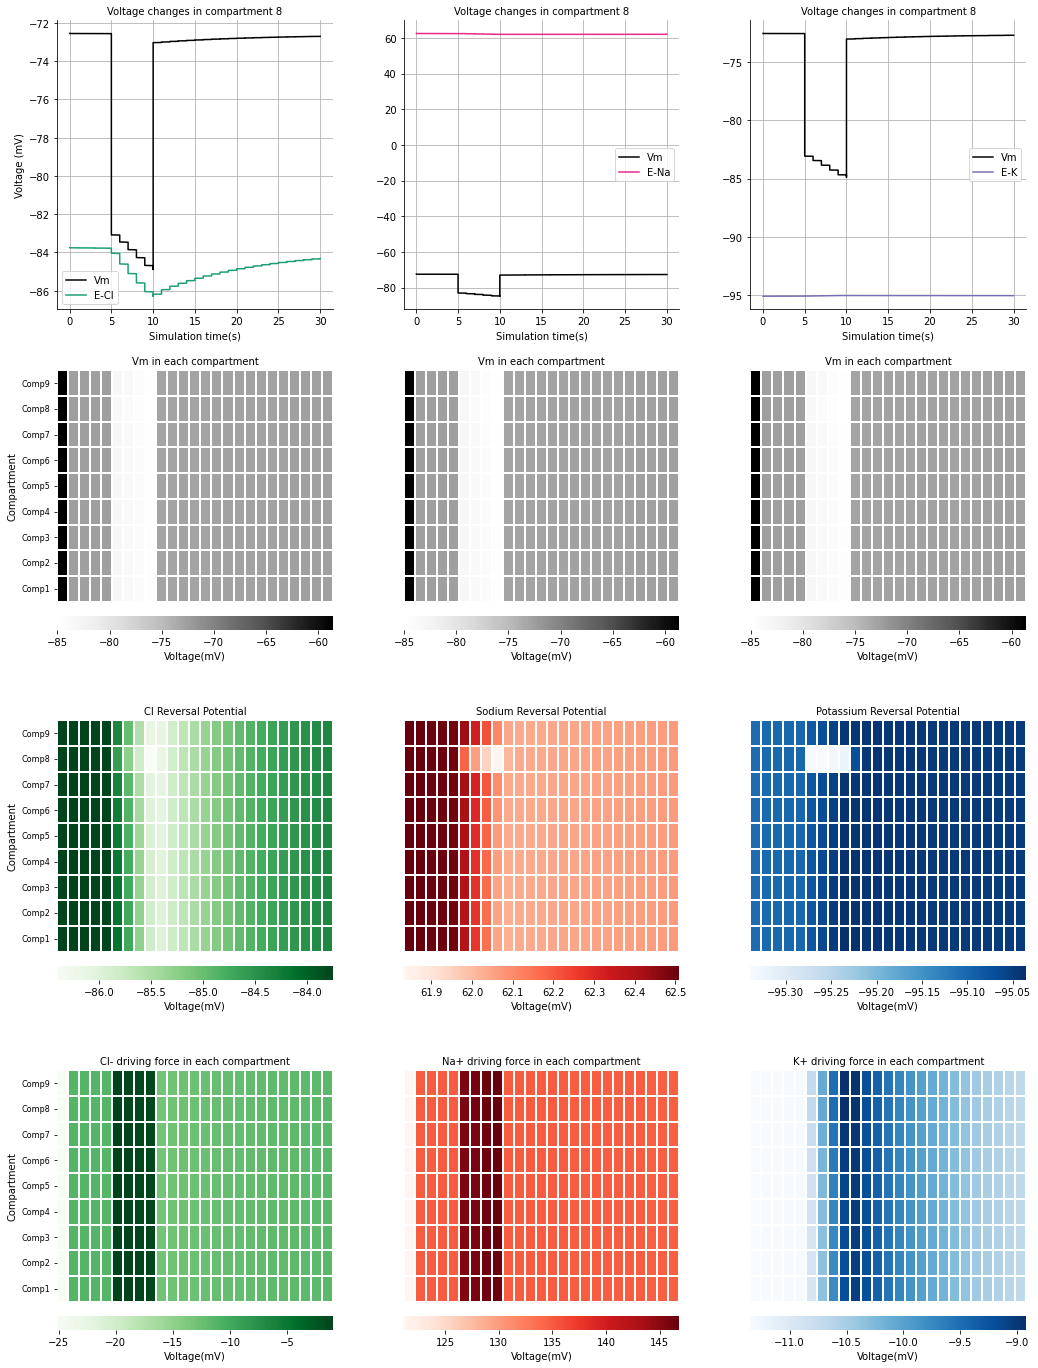

In [59]:
########################################
# GUI
########################################

btn_f1b = widgets.Button(description="Plot 1B", button_style='info')
output_f1b = widgets.Output()

display(btn_f1b, output_f1b)



########################################
# BACKEND
########################################

def btn_f1b_clicked(b):

    f1b, [(left_ax_c8, mid_ax_c8, right_ax_c8),
          (left_ax_vm,mid_ax_vm,right_ax_vm),(left_ax_ecl, mid_ax_ena, right_ax_ek), (left_ax_dfcl, mid_ax_dfna, right_ax_dfk)] = mplt.subplots(4,3, figsize=(15,20))
    f1b.tight_layout(pad=4.0)
    
    R = 8.31446
    F: float = 96485.33  # Faraday's constant        C mol-1
    T = 37 + 273.15
    RTF = R * T / F
    
    x_arr = [round(t_arr[i]) for i in range(len(t_arr))]
    
    
    

    ###### COMP-8 GRAPHS
    
    
    ek_arr = [ master_arr[8][i][-2]*1e3 for i in range(len(master_arr[8])) ]
    ena_arr = [ (-1*RTF * np.log(master_arr[8][i][4]/145e-3))*1e3 for i in range(len(master_arr[8]))]
    ecl_arr = [ master_arr[8][i][-1]*1e3 for i in range(len(master_arr[8])) ]
    vm_arr = [ master_arr[8][i][-3]*1e3 for i in range(len(master_arr[8])) ]
    
    left_ax_c8.plot(x_arr[10:],vm_arr[10:], label='Vm', color = '#000000')
    left_ax_c8.plot(x_arr[10:],ecl_arr[10:], label ='E-Cl', color ='#1b9e77')
    left_ax_c8.legend()
    left_ax_c8.set_ylabel("Voltage (mV)")
    left_ax_c8.set_xlabel("Simulation time(s)")
    left_ax_c8.set_title("Voltage changes in compartment 8",fontsize=10)
    left_ax_c8.grid()
    sns.despine()
    
    mid_ax_c8.plot(x_arr[10:],vm_arr[10:], label='Vm', color = '#000000')
    mid_ax_c8.plot(x_arr[10:],ena_arr[10:], label ='E-Na',color ='#e7298a')
    mid_ax_c8.legend()
    mid_ax_c8.set_xlabel("Simulation time(s)")
    mid_ax_c8.set_title("Voltage changes in compartment 8",fontsize=10)
    mid_ax_c8.grid()
    sns.despine()
    
    right_ax_c8.plot(x_arr[10:],vm_arr[10:], label='Vm', color = '#000000')
    right_ax_c8.plot(x_arr[10:],ek_arr[10:], label ='E-K',color ='#7570b3')
    right_ax_c8.legend()
    right_ax_c8.set_xlabel("Simulation time(s)")
    right_ax_c8.set_title("Voltage changes in compartment 8",fontsize=10)
    right_ax_c8.grid()
    sns.despine()
    
    
    ####### HEAT MAPS
    
    vm_arr = []
    ecl_arr_heatmap, ena_arr_heatmap, ek_arr_heatmap = [],[],[]
    cldf_arr, nadf_arr, kdf_arr = [],[],[]
    
    for i in range(len(comp_names_arr)-1,-1,-1):
        
        temp_arr_vm = [master_arr[i][j][-3]*1e3 for j in range(len(master_arr[0]))] 
        temp_arr_vm = temp_arr_vm[1::40]
        vm_arr.append(temp_arr_vm)
        
        ###########
        ecl_arr =[ master_arr[i][j][-1]*1e3 for j in range(len(master_arr[8]))]
        temp_arr_cl = ecl_arr[1::40]
        ecl_arr_heatmap.append(temp_arr_cl)
        
        ena_arr =[ (-1*RTF * np.log(master_arr[i][j][4]/145e-3))*1e3 for j in range(len(master_arr[8]))]
        temp_arr_mid = ena_arr[1::40]
        ena_arr_heatmap.append(temp_arr_mid)
        
        ek_arr = [ master_arr[i][j][-2]*1e3 for j in range(len(master_arr[8])) ]
        temp_arr_right = ek_arr[1::40]
        ek_arr_heatmap.append(temp_arr_right)
        
        ###########
        temp_arr_df= [master_arr[i][j][-1]*1e3 - master_arr[i][j][-3]*1e3 for j in range(len(master_arr[0]))] 
        temp_arr_cl2 = temp_arr_df[1::40]
        cldf_arr.append(temp_arr_cl2)
        
        temp_arr_df= [(-1*RTF * np.log(master_arr[i][j][4]/145e-3))*1e3 - master_arr[i][j][-3]*1e3 for j in range(len(master_arr[0]))] 
        temp_arr_na2 = temp_arr_df[1::40]
        nadf_arr.append(temp_arr_na2)
        
        temp_arr_df = [master_arr[i][j][-2]*1e3 - master_arr[i][j][-1]*1e3 for j in range(len(master_arr[0]))] 
        temp_arr_k2 = temp_arr_df[1::40]
        kdf_arr.append(temp_arr_k2)
        
        
    
    ####################
    grey_heatmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
    
    g_vm_left = sns.heatmap(vm_arr,cmap="Greys",xticklabels=False,  cbar_kws={'pad':0.05,'label':'Voltage(mV)', 'orientation':'horizontal' }, ax=left_ax_vm,linewidth=0.01 )
    g_vm_left.set_ylabel("Compartment",fontsize=10)
    g_vm_left.set_yticklabels(comp_names_arr[::-1], fontsize=8, rotation=0)
    left_ax_vm.set_title("Vm in each compartment",fontsize=10)    
        
    g_vm_mid = sns.heatmap(vm_arr,cmap="Greys",xticklabels=False, yticklabels=False,  cbar_kws={'pad':0.05,'label':'Voltage(mV)', 'orientation':'horizontal' }, ax=mid_ax_vm,linewidth=0.01 )
    #g_vm_mid.set_ylabel("Compartment",fontsize=10)
    #g_vm_mid.set_yticklabels(comp_names_arr[-1:0:-1], fontsize=8, rotation=0)
    mid_ax_vm.set_title("Vm in each compartment",fontsize=10)  
    
    g_vm_right = sns.heatmap(vm_arr,cmap="Greys",xticklabels=False, yticklabels=False, cbar_kws={'pad':0.05,'label':'Voltage(mV)', 'orientation':'horizontal' }, ax=right_ax_vm,linewidth=0.01 )
    #g_vm_right.set_ylabel("Compartment",fontsize=10)
    #g_vm_right.set_yticklabels(comp_names_arr[-1:0:-1], fontsize=8, rotation=0)
    right_ax_vm.set_title("Vm in each compartment",fontsize=10)  
    ######################
    g_ecl_left = sns.heatmap(ecl_arr_heatmap,cmap="Greens",xticklabels=False,  cbar_kws={'pad':0.05,'label':'Voltage(mV)', 'orientation':'horizontal' }, ax=left_ax_ecl,linewidth=0.01 )
    g_ecl_left.set_ylabel("Compartment",fontsize=10)
    g_ecl_left.set_yticklabels(comp_names_arr[::-1], fontsize=8, rotation=0)
    left_ax_ecl.set_title("Cl Reversal Potential",fontsize=10)
    
    g_ena_mid = sns.heatmap(ena_arr_heatmap,cmap="Reds",xticklabels=False, yticklabels=False, cbar_kws={'pad':0.05,'label':'Voltage(mV)', 'orientation':'horizontal' }, ax=mid_ax_ena,linewidth=0.01 )
    #g_ena_mid.set_ylabel("Compartment",fontsize=10)
    #g_ena_mid.set_yticklabels(comp_names_arr[-1:0:-1], fontsize=8, rotation=0)
    mid_ax_ena.set_title("Sodium Reversal Potential",fontsize=10)
    
    g_ek_right = sns.heatmap(ek_arr_heatmap,cmap="Blues",xticklabels=False, yticklabels=False, cbar_kws={'pad':0.05,'label':'Voltage(mV)', 'orientation':'horizontal' }, ax=right_ax_ek,linewidth=0.01 )
    #g_ek_right.set_ylabel("Compartment",fontsize=10)
    #g_ek_right.set_yticklabels(comp_names_arr[-1:0:-1], fontsize=8, rotation=0)
    right_ax_ek.set_title("Potassium Reversal Potential",fontsize=10)
    ########################
    
    g_cldf = sns.heatmap(cldf_arr,cmap="Greens",xticklabels=False,  cbar_kws={'pad':0.05,'label':'Voltage(mV)', 'orientation':'horizontal' }, ax=left_ax_dfcl,linewidth=0.01 )
    g_cldf.set_ylabel("Compartment",fontsize=10)
    g_cldf.set_yticklabels(comp_names_arr[::-1], fontsize=8, rotation=0)
    left_ax_dfcl.set_title("Cl- driving force in each compartment",fontsize=10)
    
    g_nadf = sns.heatmap(nadf_arr,cmap="Reds",xticklabels=False, yticklabels=False, cbar_kws={'pad':0.05,'label':'Voltage(mV)', 'orientation':'horizontal' }, ax=mid_ax_dfna,linewidth=0.01 )
    #g_lower_mid.set_ylabel("Compartment",fontsize=10)
    #g_lower_mid.set_yticklabels(comp_names_arr[-1:0:-1], fontsize=8, rotation=0)
    mid_ax_dfna.set_title("Na+ driving force in each compartment",fontsize=10)
    
    g_kdf = sns.heatmap(kdf_arr,cmap="Blues",xticklabels=False, yticklabels=False, cbar_kws={'pad':0.05,'label':'Voltage(mV)', 'orientation':'horizontal' }, ax=right_ax_dfk, linewidth=0.01 )
    #g_lower_right.set_ylabel("Compartment",fontsize=10)
    #g_lower_right.set_yticklabels(comp_names_arr[-1:0:-1], fontsize=8, rotation=0)
    right_ax_dfk.set_title("K+ driving force in each compartment",fontsize=10)
    ###########################


# IMPLEMENTATION
########################################

btn_f1b.on_click(btn_f1b_clicked)